In [1]:
import numpy as np
import pandas as pd
import sklearn

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn import datasets, metrics, tree, ensemble
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, matthews_corrcoef, f1_score
%pylab inline

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer


Populating the interactive namespace from numpy and matplotlib


In [2]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
set(train.columns)-set(test.columns)

{'SalePrice'}

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_id = test['Id']
del train['Id']
del test['Id']

In [6]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
set(train.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [8]:
def make_categorical_and_numeric(df):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    numeric_features = numeric.columns
    all_features = df.columns
    categ_features = list(set(all_features) - set(numeric_features))

    # fill na in numeric, fill it with median
    numeric = numeric.fillna(numeric.median()) 

    # fill na in categorical, fill with most frequent
    categ = df[categ_features].apply(lambda x:x.fillna(x.value_counts().index[0])) 
    
    return categ, numeric

In [9]:
train_c, train_n = make_categorical_and_numeric(train)

In [10]:
enc = OneHotEncoder()
enc.fit(train_c)
train_c = pd.DataFrame(enc.transform(train_c).toarray(),columns=enc.get_feature_names())

In [11]:
train_c.head()

,x0_Corner,x0_CulDSac,x0_FR2,x0_FR3,x0_Inside,x1_AsbShng,x1_AsphShn,x1_Brk Cmn,x1_BrkFace,x1_CBlock,...,x41_CWD,x41_Con,x41_ConLD,x41_ConLI,x41_ConLw,x41_New,x41_Oth,x41_WD,x42_Grvl,x42_Pave
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [12]:
test_c, test_n = make_categorical_and_numeric(test)
test_c = pd.DataFrame(enc.transform(test_c).toarray(),columns=enc.get_feature_names())
test_c.head()

,x0_Corner,x0_CulDSac,x0_FR2,x0_FR3,x0_Inside,x1_AsbShng,x1_AsphShn,x1_Brk Cmn,x1_BrkFace,x1_CBlock,...,x41_CWD,x41_Con,x41_ConLD,x41_ConLI,x41_ConLw,x41_New,x41_Oth,x41_WD,x42_Grvl,x42_Pave
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [13]:
X = pd.concat([train_n, train_c], axis=1)
y = X['SalePrice'].to_numpy()
X = X.drop(columns = 'SalePrice')

In [14]:
X_test = pd.concat([test_n, test_c], axis=1)

In [15]:
X_test.shape, X.shape

((1459, 288), (1460, 288))

In [16]:
del train_n['SalePrice']

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import seaborn as sns

def make_corr_heatmap(X):
    X_corr = X.corr()
    X_corr[np.isfinite(X_corr )==0 ] =0

    Z=linkage(X_corr, 'complete') 
    leaves = leaves_list(Z)
    
    
    from operator import itemgetter
    high_correlated_pairs = []
    pairs = []
    columns = X_corr.columns
    for idx, rows in X_corr.iterrows():
        for col in columns:
            if abs(rows[col]) > 0.01 and idx != col:
                if [idx, col, rows[col]] not in pairs and [col, idx, rows[col]] not in pairs:
                    pairs.append([idx, col, rows[col]])
    pairs = sorted(pairs, key=itemgetter(2))
    for j in pairs:
        if abs(j[2])>0.75:
            print(j[0], '\t', j[1], '\t', j[2])
            high_correlated_pairs.append(j[0])

    
    

    plt.figure(figsize=(18, 18))
    sns.heatmap(X[X.columns[leaves]].corr(), cmap = 'rainbow')
    return high_correlated_pairs
    #print(X_corr)

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler_mm = MinMaxScaler()
scaler_mm.fit(X)
m1 = pd.DataFrame(scaler_mm.transform(X), columns = X.columns, index=X.index)
X_test_mm = pd.DataFrame(scaler_mm.transform(X_test), columns = X_test.columns, index=X_test.index)

scaler_stand = StandardScaler()
scaler_stand.fit(X)
s1 = pd.DataFrame(scaler_stand.transform(X), columns = X.columns, index=X.index)
X_test_stand = pd.DataFrame(scaler_stand.transform(X_test), columns = X_test.columns, index=X_test.index)



# scaler_mm = MinMaxScaler()
# scaler_stand = StandardScaler()
# mm = scaler_mm.fit_transform(X)
# stand = scaler_stand.fit_transform(X)

In [19]:
m1

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,x41_CWD,x41_Con,x41_ConLD,x41_ConLI,x41_ConLw,x41_New,x41_Oth,x41_WD,x42_Grvl,x42_Pave
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1456,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1457,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1458,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [20]:
s1

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,x41_CWD,x41_Con,x41_ConLD,x41_ConLI,x41_ConLw,x41_New,x41_Oth,x41_WD,x42_Grvl,x42_Pave
0,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.064238,0.064238
1,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.064238,0.064238
2,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.064238,0.064238
3,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.064238,0.064238
4,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.064238,0.064238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073375,-0.357114,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,-0.288653,...,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.064238,0.064238
1456,-0.872563,0.687385,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,0.722112,...,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.064238,0.064238
1457,0.309859,-0.175462,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,-0.288653,...,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.064238,0.064238
1458,-0.872563,-0.084636,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,6.092188,...,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.064238,0.064238


x14_N 	 x14_Y 	 -1.0
x25_AllPub 	 x25_NoSeWa 	 -1.0
x27_Grvl 	 x27_Pave 	 -1.0
x42_Grvl 	 x42_Pave 	 -1.0
x22_Gable 	 x22_Hip 	 -0.9334615823692267
x28_IR1 	 x28_Reg 	 -0.9259589789196699
x31_Gtl 	 x31_Mod 	 -0.9086074526366464
x23_Gd 	 x23_TA 	 -0.9061205814782314
x7_Gd 	 x7_TA 	 -0.8945667598844518
x37_Gd 	 x37_TA 	 -0.8652668096676542
x16_FuseA 	 x16_SBrkr 	 -0.8572829837352558
x13_N 	 x13_Y 	 -0.8564908886472611
x40_Fa 	 x40_TA 	 -0.8341966310949238
x24_Gd 	 x24_TA 	 -0.8244565220642256
x39_Attchd 	 x39_Detchd 	 -0.8208938250696841
MSSubClass 	 x29_1Fam 	 -0.817460500961876
x15_RL 	 x15_RM 	 -0.808585354636309
x3_Fa 	 x3_TA 	 -0.8074873062480362
x34_Gd 	 x34_TA 	 -0.8065471655738156
x20_BrkFace 	 x20_None 	 -0.8063369540930418
BsmtFinSF2 	 x21_Unf 	 -0.7995055975750244
2ndFlrSF 	 x26_1Story 	 -0.7887493033172002
x2_CBlock 	 x2_PConc 	 -0.7815584678082255
x41_New 	 x41_WD 	 -0.7736802516813371
x9_Partial 	 x41_WD 	 -0.7695593050913268
x0_Corner 	 x0_Inside 	 -0.7526768997643796
x1_P

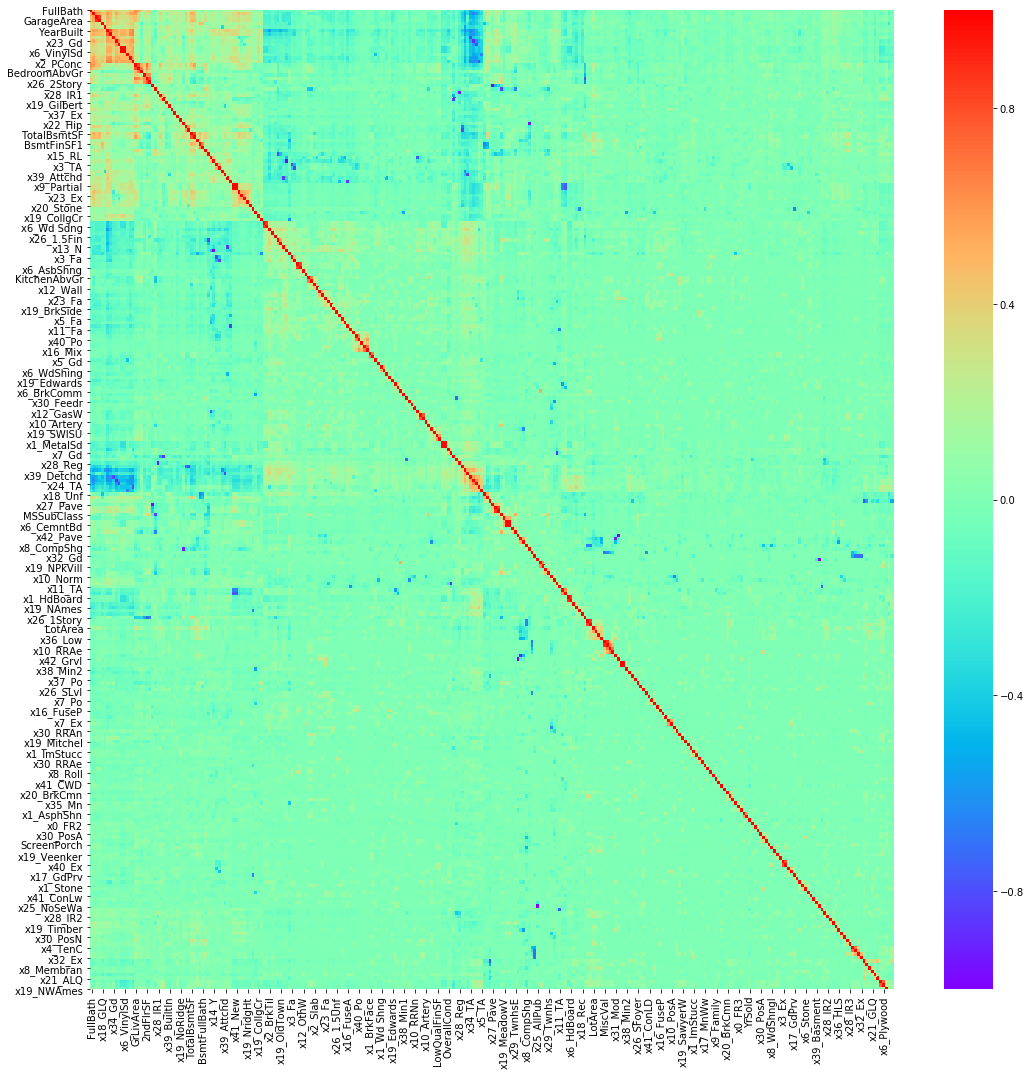

In [21]:
pairs = make_corr_heatmap(X)

In [22]:
pairs[:5]

['x14_N', 'x25_AllPub', 'x27_Grvl', 'x42_Grvl', 'x22_Gable']

In [23]:
X_corr_pairs = X.drop(columns = pairs)
X_test_corr_pairs = X_test.drop(columns = pairs)

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
selector = SelectKBest(f_regression, k=50)
selector.fit(X, y)
cols1 = selector.get_support(indices=True)
X_f_regr50 = X.iloc[:,cols1]
X_test_f_regr50 = X_test.iloc[:,cols1]


selector = SelectKBest(f_regression, k=100)
selector.fit(X, y)
cols = selector.get_support(indices=True)
X_f_regr100 = X.iloc[:,cols]
X_test_f_regr100 = X_test.iloc[:,cols]

selector = SelectKBest(f_regression, k=150)
selector.fit(X, y)
cols = selector.get_support(indices=True)
X_f_regr150 = X.iloc[:,cols]
X_test_f_regr150 = X_test.iloc[:,cols]

In [25]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import make_scorer


def rmsle(y, y_pred):
    mask = y_pred > 0
    return np.sqrt(mean_squared_log_error(y[mask], y_pred[mask]))


processing = ['minmaxscaler', 'standardscaler', 'deleting_high_corr',
              'f_regr50', 'f_regr100', 'f_regr150',
              'only numeric', 'only categ']
train_test = [(m1, X_test_mm), (s1, X_test_stand), 
              (X_corr_pairs, X_test_corr_pairs), (X_f_regr50, X_test_f_regr50),
              (X_f_regr100, X_test_f_regr100), (X_f_regr150, X_test_f_regr150),
              (train_n, test_n),(train_c, test_c)]
models = {}
cross_val_scores = {}
predictions = {}
for i in range(len(processing)):
    reg = LinearRegression()
    reg.fit(train_test[i][0],y)
    models[processing[i]] = reg
    # cv = cross_val_score(estimator=reg, X=train_test[i][0], y=y,
    #             cv=5, scoring='neg_mean_squared_error')
    cv = cross_val_score(estimator=reg, X=train_test[i][0], y=y,
                cv=5, scoring=make_scorer(rmsle))
    cross_val_scores[processing[i]] = np.mean(cv)
    predictions[processing[i]] = reg.predict(train_test[i][1])

In [26]:
cross_val_scores

{'minmaxscaler': 2.1575106539812268,
 'standardscaler': 2.5484889349313082,
 'deleting_high_corr': 0.19145796413742283,
 'f_regr50': 0.16185730869223425,
 'f_regr100': 0.16052786934416693,
 'f_regr150': 0.16718558348898438,
 'only numeric': 0.19796144789687264,
 'only categ': 2.9058604739844003}

In [27]:
predictions

{'minmaxscaler': array([172833., 211302., 247021., ..., 239199., 167651., 281653.]),
 'standardscaler': array([173912.15805187, 212780.15805187, 247604.15805187, ...,
        239240.15805187, 169308.15805187, 281864.15805187]),
 'deleting_high_corr': array([222045.4831601 , 266949.67735661, 284817.07482837, ...,
        283656.71657241, 205107.88267432, 315319.21875725]),
 'f_regr50': array([112757.92405053, 154467.07461741, 175591.75559608, ...,
        159764.00958811, 111672.57877137, 218087.61284563]),
 'f_regr100': array([262740.94588028, 305969.81825597, 324323.66661509, ...,
        301405.45810844, 277755.64804568, 377988.00036639]),
 'f_regr150': array([303057.08182936, 347581.67568233, 367385.51435695, ...,
        353366.44506273, 308393.95829086, 412758.63710588]),
 'only numeric': array([116609.69989067, 151819.21417163, 172826.57474865, ...,
        171198.19431086, 101401.67818601, 252855.01705272]),
 'only categ': array([328608., 356608., 394624., ..., 333824., 326976.,

In [28]:
from sklearn.model_selection import KFold
good_sets = ['deleting_high_corr',
              'f_regr50', 'f_regr100', 'f_regr150',
              'only numeric']
models = [LinearRegression() for g in good_sets]
good_x = [X_corr_pairs, X_f_regr50, X_f_regr100, X_f_regr150,
              train_n]

kf = KFold(n_splits=5, random_state=42)
cv_scores = []
for train_index, test_index in kf.split(y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    xtrain = list(map(lambda x: x.to_numpy()[train_index], good_x))
    xtest = list(map(lambda x: x.to_numpy()[test_index], good_x))
    ytrain, ytest = np.log(y[train_index]), np.log(y[test_index])

    for i in range(len(models)):
        models[i].fit(xtrain[i], ytrain)
    pred = np.mean([m.predict(x) for m,x in zip(models, xtest)], axis=0)
    
    rmsle_err = rmsle(ytest, pred)
    cv_scores+=[rmsle_err]
cv_models_mean = np.mean(cv_scores)

In [29]:
cv_scores

[0.008730106345303452,
 0.011418328989951952,
 0.00989727315361685,
 0.009129677545836386,
 0.013859798168000793]

In [30]:
cv_models_mean

0.010607036840541888

In [31]:
res_models_mean = np.mean([predictions[g] for g in good_sets], axis=0)
res_models_mean

array([203442.22696219, 245357.49201679, 264988.91722903, ...,
       253878.16472851, 200866.34919365, 315401.69722557])

In [32]:
predictions['mean'] = res_models_mean

In [33]:
for key in predictions:
    p = pd.DataFrame(predictions[key])
    s = pd.concat([test_id, p], axis=1)
    s.columns = ['Id','SalePrice']
    s.to_csv(key + '.csv', index=False)



In [34]:
df = pd.DataFrame({'Model': ['minmaxscaler', 'standardscaler', 'deleting_high_corr', 'f_regr50',
                             'f_regr100', 'f_regr150', 'only numeric', 'only categ', 'mean' ],
                   'Kaggle score': [0.89993, 0.92322, 0.52091, 0.16126, 
                                    0.71818, 0.83333, 0.22071, 1.40516, 0.48675]})

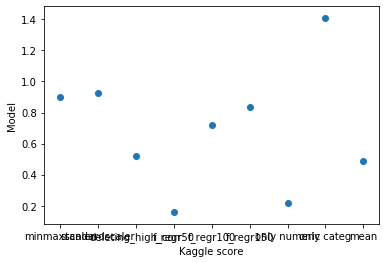

In [35]:
plt.scatter(df['Model'], df['Kaggle score'])
plt.xlabel('Kaggle score')
plt.ylabel("Model")
plt.show()

итого лучший рез-т на 50 лучших признаках, а хуже всего работают отдельно взятые категориальные